In [19]:
import pandas as pd

data = pd.read_csv('data.csv')
data = pd.DataFrame(data)
data.head()
data.columns

Index(['Unnamed: 0', 'approved_at_utc', 'approved_by', 'archived', 'author',
       'author_cakeday', 'author_flair_css_class', 'author_flair_template_id',
       'author_flair_text', 'banned_at_utc', 'banned_by', 'can_gild',
       'can_mod_post', 'clicked', 'contest_mode', 'created', 'created_utc',
       'crosspost_parent', 'crosspost_parent_list', 'distinguished', 'domain',
       'downs', 'edited', 'gilded', 'hidden', 'hide_score', 'id',
       'is_crosspostable', 'is_reddit_media_domain', 'is_self', 'is_video',
       'likes', 'link_flair_css_class', 'link_flair_text', 'locked', 'media',
       'media_embed', 'media_metadata', 'media_only', 'mod_note',
       'mod_reason_by', 'mod_reason_title', 'mod_reports', 'name', 'no_follow',
       'num_comments', 'num_crossposts', 'num_reports', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'post_categories',
       'post_hint', 'preview', 'previous_visits', 'pwls', 'quarantine',
       'removal_reason', 'report_reaso

In [20]:
data.drop('Unnamed: 0', axis = 1, inplace = True)
data.head()
data.shape

(22580, 85)

In [21]:
#Predicting binary variable: low vs high comments
    #low defined as <= median number of comments/post: <= 12
    #high defined as > median number of comments/post: > 12
    
import numpy as np

median_comments = np.median(data['num_comments'])
median_comments

12.0

In [22]:
#Add in binary label as target in dataset
data['binary_comments'] = [False if i <= 12 else True for i in data['num_comments']]
data['binary_comments'].head()

#check values
    #51% of posts labeled low: False (inclusive of 12)
    #49% of posts labeled high: True (exclusive of 12)
data['binary_comments'].value_counts()


False    11593
True     10987
Name: binary_comments, dtype: int64

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


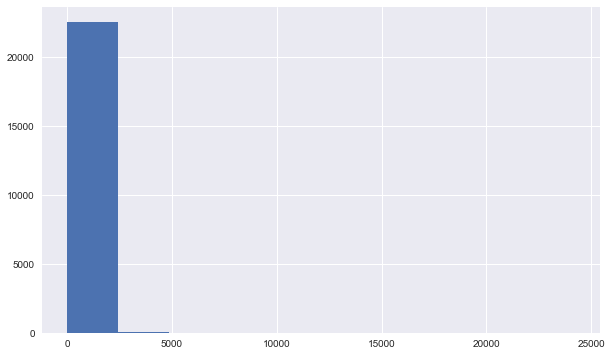

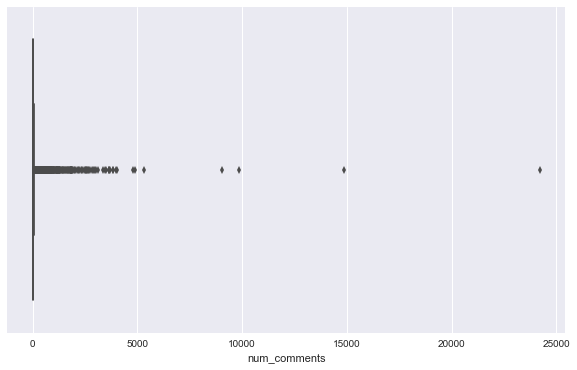

In [23]:
#Plot distribution of num_comments/post
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize = (10, 6))
plt.hist(data['num_comments']);

fig = plt.figure(figsize = (10, 6))
sns.boxplot(data['num_comments']);

In [24]:
#baseline accuracy for model is % of high comments
baseline = data['binary_comments'].value_counts()[1] / (len(data['binary_comments']))
baseline

0.4865810451727192

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

funny                   89
aww                     81
gaming                  66
pics                    63
memes                   62
FortNiteBR              61
PrequelMemes            58
PewdiepieSubmissions    55
gifs                    55
LiverpoolFC             51
rupaulsdragrace         50
Showerthoughts          50
mildlyinteresting       50
todayilearned           47
DDLC                    46
DeepFriedMemes          45
oddlysatisfying         44
LivestreamFail          43
greatawakening          43
tumblr                  42
AskReddit               42
MemeEconomy             41
BlackPeopleTwitter      40
FireEmblemHeroes        40
wholesomememes          39
CringeAnarchy           39
OldSchoolCool           37
greentext               37
cursedimages            36
interestingasfuck       36
                        ..
doge                     1
othepelican              1
Rochester                1
desmoines                1
reckful                  1
RTLSDR                   1
K

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


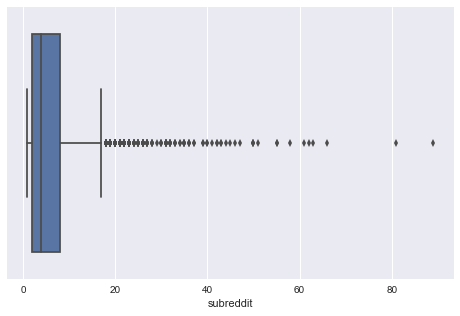

In [44]:
#set feature and target variables
X = data['subreddit']
y = data['binary_comments']

fig = plt.figure(figsize = (8, 5))
sns.boxplot(X.value_counts(), orient = 'h');

#print(type(X))
print(X.value_counts())
print(data.groupby(['subreddit'])['num_comments'].median().sort_values(ascending = False))

In [45]:
#additional step: group similar subreddits

#from nltk.stem import WordNetLemmatizer
#lemmatizer = WordNetLemmatizer()
#X_lemma = [lemmatizer.lemmatize(i) for i in X]
#for i in X:
#    print (i, lemmatizer.lemmatize(i))

#CountVectorize feature set
cv = CountVectorizer(stop_words = 'english')
cv.fit(X)
cv_X = cv.fit_transform(X)
cv_X_array = cv_X.toarray()

print('cv_X:', type(cv_X))
print('cv_X_array:', type(cv_X_array))
print(cv_X_array.shape, y.shape)


cv_X: <class 'scipy.sparse.csr.csr_matrix'>
cv_X_array: <class 'numpy.ndarray'>
(22580, 3734) (22580,)


In [46]:
#train-test-split dataset
cv_X_train, cv_X_test, y_train, y_test = train_test_split(cv_X_array, y, test_size = 0.3)

print(cv_X_train.shape, y_train.shape)
print(cv_X_test.shape, y_test.shape)


(15806, 3734) (15806,)
(6774, 3734) (6774,)


In [47]:
#1. Logistic regression classifier
lr = LogisticRegression()
lr.fit(cv_X_train, y_train)
print('train:', lr.score(cv_X_train, y_train))

print('test:', lr.score(cv_X_test, y_test))

train: 0.8007085916740478
test: 0.7171538234425745


In [51]:
#2a. KNN with k = 1 classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(cv_X_train, y_train)
print(knn.score(cv_X_train, y_train))

print(knn.score(cv_X_test, y_test))

0.7446539288877642
0.6803956303513433


#TIMED OUT

#2b. KNN with k = [3, 5, 7, 9, 11]
k = [3, 5, 7, 9, 11]
k_train = []
k_test = []
for i in k:
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(cv_X_train, y_train)
    k_train.append(knn.score(cv_X_train, y_train))
    k_test.append(knn.score(cv_X_test, y_test))
    
    print(k, knn.score(cv_X_train, y_train))
    print(k, knn.score(cv_X_test, y_test))

In [52]:
#3. Random Forest classifier
rf = RandomForestClassifier()
rf.fit(cv_X_train, y_train)
print('train:', rf.score(cv_X_train, y_train))

print('test:', rf.score(cv_X_test, y_test))

train: 0.7969758319625458
test: 0.6784765279007972


In [ ]:
#Plotting results


In [14]:
#Adding in new variables for thread title
    #1. binary variable if 'cat' or 'funny' appears in title
    #2. numerical variable for length of title: number of words
    #3. numerical variable for intensity of title: punctuation - ?s and !s
    #4. additional step: creating dictionary of words for classifying positive/negative sentiment


In [15]:
#1. binary variable if 'cat' or 'funny' appears in title
import numpy as np
binary_variable = [1 if ('cat' in i) or ('funny' in i) else 0 for i in data['title']]
binary_variable = pd.Series(binary_variable)

data['binary_variable'] = binary_variable
data['binary_variable'].value_counts()

#i = data['title'][0]
#for i in data['title']:
#    if ('cat' or 'funny') in i:
#        print (i, True)
        
#returns df rows for condition: np.where(data['title'].str.contains('cat'))


0    22273
1      307
Name: binary_variable, dtype: int64

In [16]:
#checking for 'cat' and 'funny'

#X['cat_variable'] = data['title'].str.contains('cat')
#X['funny_variable'] = data['title'].str.contains('funny')

#print(X['cat_variable'].value_counts())
#print ('\n')
#print(X['funny_variable'].value_counts())

In [17]:
#CountVectorizer with binary_variable
X = data['subreddit']

cv = CountVectorizer(stop_words = 'english')
cv.fit(X)
cv_X = cv.fit_transform(X)
cv_X_array = cv_X.toarray()

print(cv_X_array.shape)

(22580, 3734)


In [18]:
cv_X = pd.DataFrame(cv_X_array)
cv_X['binary_variable'] = data['binary_variable']
print(cv_X.shape)


(22580, 3735)


In [19]:
#train-test-split dataset
cv_X_train, cv_X_test, y_train, y_test = train_test_split(cv_X, y, test_size = 0.3)

print(cv_X_train.shape, y_train.shape)
print(cv_X_test.shape, y_test.shape)

(15806, 3735) (15806,)
(6774, 3735) (6774,)


In [20]:
#Random Forest classifier with binary_variable
rf = RandomForestClassifier()
rf.fit(cv_X_train, y_train)
print('train:', rf.score(cv_X_train, y_train))

print('test:', rf.score(cv_X_test, y_test))

train: 0.791155257497153
test: 0.672128727487452


In [21]:
#Binary variable did not improve model...decreased performance

In [22]:
#2. numerical variable for length of title: number of words
    #additional step: categorize into bins

data['num_variable'] = [len(i.split()) for i in data['title']]
data['num_variable'].value_counts().head()

5    2020
4    1986
3    1924
6    1824
7    1693
Name: num_variable, dtype: int64

In [23]:
#3. numerical variable for intensity of title: punctuation - ?s and !s
data['intensity_variable'] = [(i.count('!') + i.count('?')) for i in data['title']]
data['intensity_variable'].value_counts()

#for i in data['title']:
#    print(i.count('!') + i.count('?'))

0     18835
1      3153
2       378
3       138
4        42
5        15
6        10
7         3
9         2
8         2
10        1
20        1
Name: intensity_variable, dtype: int64

In [24]:
cv_X['num_variable'] = data['num_variable']
cv_X['intensity_variable'] = data['intensity_variable']

print(cv_X.shape)
cv_X.head()


(22580, 3737)


,0,1,2,3,4,5,6,7,8,9,...,3727,3728,3729,3730,3731,3732,3733,binary_variable,num_variable,intensity_variable
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,39,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,18,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,23,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,21,0


In [25]:
#train-test-split dataset
cv_X_train, cv_X_test, y_train, y_test = train_test_split(cv_X, y, test_size = 0.3)

print(cv_X_train.shape, y_train.shape)
print(cv_X_test.shape, y_test.shape)

(15806, 3737) (15806,)
(6774, 3737) (6774,)


In [26]:
#Random Forest classifier with new features
rf = RandomForestClassifier()
rf.fit(cv_X_train, y_train)
print('train:', rf.score(cv_X_train, y_train))

print('test:', rf.score(cv_X_test, y_test))

train: 0.9211691762621789
test: 0.6182462356067316


In [27]:
#Adding in num_variable and intensity_variable increased the training model score
    #decreased test set performance

In [28]:
#Using CountVectorizer to create features based on thread title
cv2 = CountVectorizer()
cv2.fit(data['title'])
cv2_X = cv2.fit_transform(data['title'])
cv2_X_array = cv2_X.toarray()


In [29]:
cv2_X = pd.DataFrame(cv2_X_array)

cv_X_all = pd.concat([cv_X, cv2_X], axis = 1)

In [30]:
print(cv_X.shape, cv2_X.shape, cv_X_all.shape)

(22580, 3737) (22580, 26050) (22580, 29787)


In [31]:
#train-test-split dataset
cv_X_all_train, cv_X_all_test, y_train, y_test = train_test_split(cv_X_all, y, test_size = 0.3)

print(cv_X_all_train.shape, y_train.shape)
print(cv_X_all_test.shape, y_test.shape)

(15806, 29787) (15806,)
(6774, 29787) (6774,)


In [32]:
#Random Forest classifier with new features
rf = RandomForestClassifier()
rf.fit(cv_X_train, y_train)
print('train:', rf.score(cv_X_train, y_train))

print('test:', rf.score(cv_X_test, y_test))

train: 0.8787802100468176
test: 0.5079716563330381


In [33]:
#Adding CountVectorizer of post title leads to better model score for training data
    #decreased test set performance

In [34]:
#Cross-validation to evaluate above model

from sklearn.model_selection import cross_val_score

train_scores = cross_val_score(rf, cv_X_all_train, y_train, cv = 5)
test_scores = cross_val_score(rf, cv_X_all_test, y_test, cv = 5)
print(train_scores, test_scores)

[0.63662239 0.63472486 0.63714015 0.62828219 0.625     ] [0.60029499 0.60738007 0.59852399 0.605613   0.57976366]


In [35]:
#Cross-validation scores show poor performance of Random Forest model with CountVectorized subreddit and title variables

In [36]:
#Non-Treebased Models
    #1. Logistic Regression
    #2. KNN
        #a. with k = 1
        #b. with k = [3, 5, 7, 9, 11]


In [37]:
#1. Logistic Regression
lr = LogisticRegression()
lr.fit(cv_X_all_train, y_train)
print(lr.score(cv_X_all_train, y_train))

print(lr.score(cv_X_all_test, y_test))

0.9305327090978109
0.6891054030115146


In [38]:
#Logistic Regression shows similarly poor performance to RF model
    #high bias: underfit model

In [39]:
#2a. KNN with k = 1
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(cv_X_all_train, y_train)
print(knn.score(cv_X_all_train, y_train))

print(knn.score(cv_X_all_test, y_test))

0.9843730229026951
0.5481251845290818


In [ ]:
#KNN with k = 1 shows high bias: training set scores higher than RandomForest model
    #decreased test set performance (worst of 3 models); KNN best fits non-linear relationships
    #test with different k values

#TIMED OUT

#2b. KNN with k = [3, 5, 7, 9, 11]
k = [3, 5, 7, 9, 11]
k_train = []
k_test = []
for i in k:
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(cv_X_all_train, y_train)
    k_train.append(knn.score(cv_X_all_train, y_train))
    k_test.append(knn.score(cv_X_all_test, y_test))
    
    print(k, knn.score(cv_X_all_train, y_train))
    print(k, knn.score(cv_X_all_test, y_test))
